Во вложении временной ряд - заказы такси в аэропорт. 
Нужно проанализироваnm закономерносnи и найти аномалии в даннsх, визуализировать полученные результаты.

# Оглавление

- [Импорт библиотек и данных](#импорт-библиотек-и-данных)
- [Разложение временного ряда на компоненты: тренд, сезонность и остатки](#разложение)
- [Isolation Forest](#isolation-forest)
- [Z-score](#z-score)

<a id = "импорт-библиотек-и-данных"></a>

# Импорт библиотек и данных

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

df = pd.read_excel('example.xlsx')

#data['datetime'] = pd.to_datetime(data['datetime'])

df.set_index('datetime', inplace=True)

print(df.head())

                     data
datetime                 
2018-03-01 00:10:00    14
2018-03-01 00:20:00    28
2018-03-01 00:30:00    20
2018-03-01 00:40:00    32
2018-03-01 00:50:00    21


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25953 entries, 2018-03-01 00:10:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   data    25953 non-null  int64
dtypes: int64(1)
memory usage: 405.5 KB


Проверка пропусков во временных метках

In [7]:
missing_time = df.index.to_series().diff().dropna()

expected_interval = pd.Timedelta(minutes=10)
large_gaps = missing_time[missing_time > expected_interval]

print(large_gaps)

datetime
2018-03-01 07:30:00   0 days 00:30:00
2018-03-02 07:40:00   0 days 00:30:00
2018-03-02 21:20:00   0 days 00:30:00
2018-03-03 08:30:00   0 days 00:30:00
2018-03-04 06:00:00   0 days 00:30:00
                            ...      
2018-08-28 08:40:00   0 days 00:30:00
2018-08-28 21:10:00   0 days 00:30:00
2018-08-29 19:30:00   0 days 00:30:00
2018-08-30 18:10:00   0 days 00:30:00
2018-08-30 23:40:00   0 days 00:30:00
Name: datetime, Length: 269, dtype: timedelta64[ns]


Добавление недостающих строк временного ряда

In [9]:
df = df.asfreq('10min')
df.isna().sum()

data    542
dtype: int64

Добавление значений методом линейной интерполяции

In [11]:
df = df.interpolate(method='linear')
example_data = df['2018-03-01 07:00:00':'2018-03-01 08:00:00']
print(example_data)    

                         data
datetime                     
2018-03-01 07:00:00  0.000000
2018-03-01 07:10:00  0.666667
2018-03-01 07:20:00  1.333333
2018-03-01 07:30:00  2.000000
2018-03-01 07:40:00  4.000000
2018-03-01 07:50:00  7.000000
2018-03-01 08:00:00  9.000000


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26495 entries, 2018-03-01 00:10:00 to 2018-08-31 23:50:00
Freq: 10min
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   data    26495 non-null  float64
dtypes: float64(1)
memory usage: 1.4 MB


Визуализация исходного временного ряда

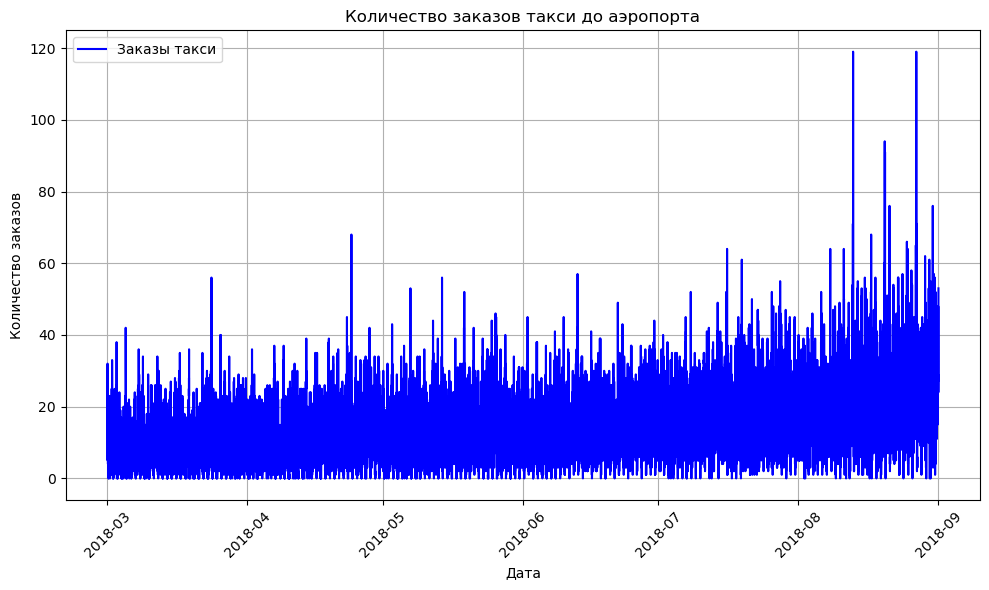

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['data'], label='Заказы такси', color='b')
plt.title('Количество заказов такси до аэропорта')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<a id = "разложение"></a>

# Разложение временного ряда на компоненты: тренд, сезонность и остатки

In [16]:
sns.set(rc={'figure.figsize':(15,4)})

def lineplot(data, title):
    data.plot()
    plt.title(title)
    plt.show()

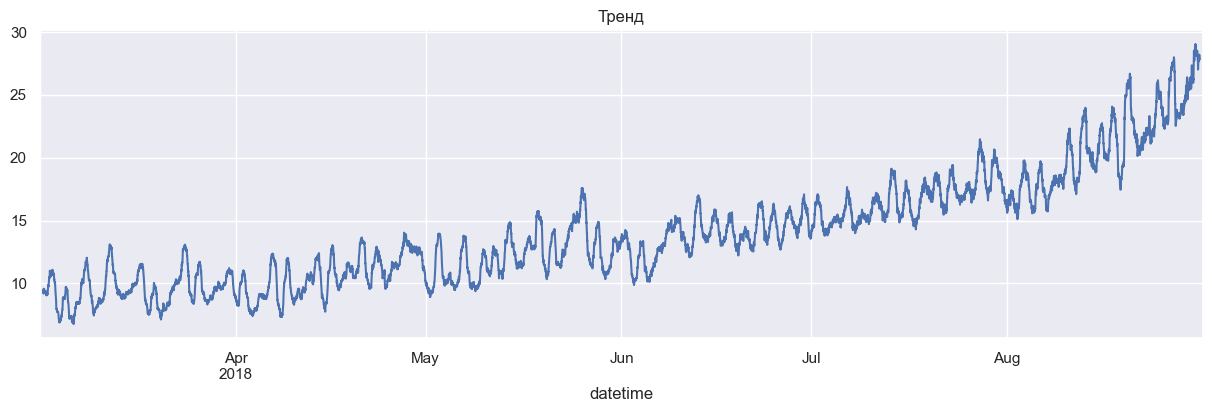

In [17]:
decomposed = seasonal_decompose(df, model='additive', period=144) 
lineplot(decomposed.trend, 'Тренд')

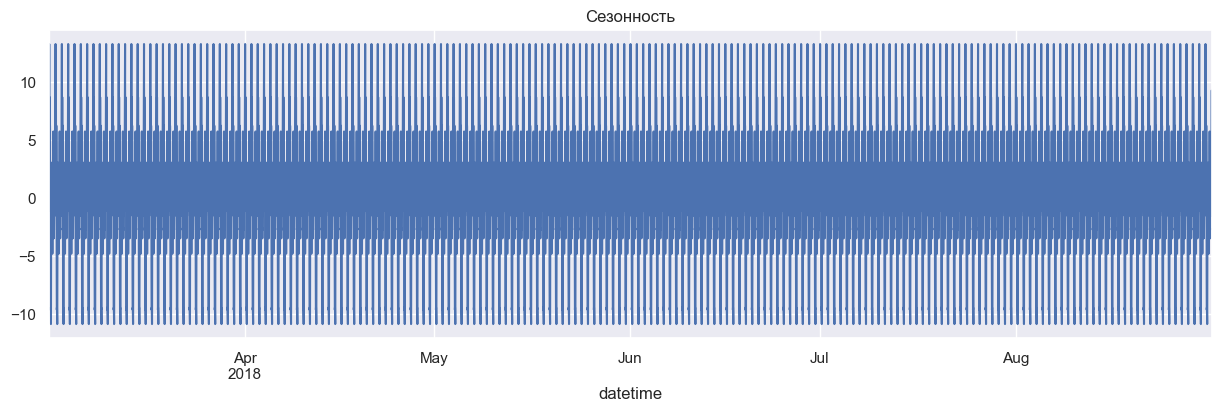

In [18]:
lineplot(decomposed.seasonal, 'Сезонность')

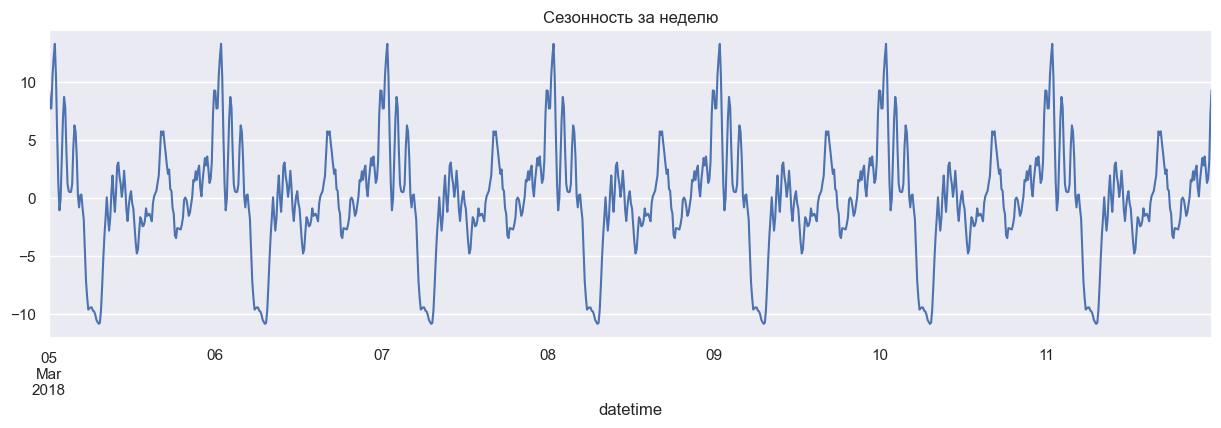

In [19]:
lineplot(decomposed.seasonal['2018-03-05':'2018-03-11'], 'Сезонность за неделю')

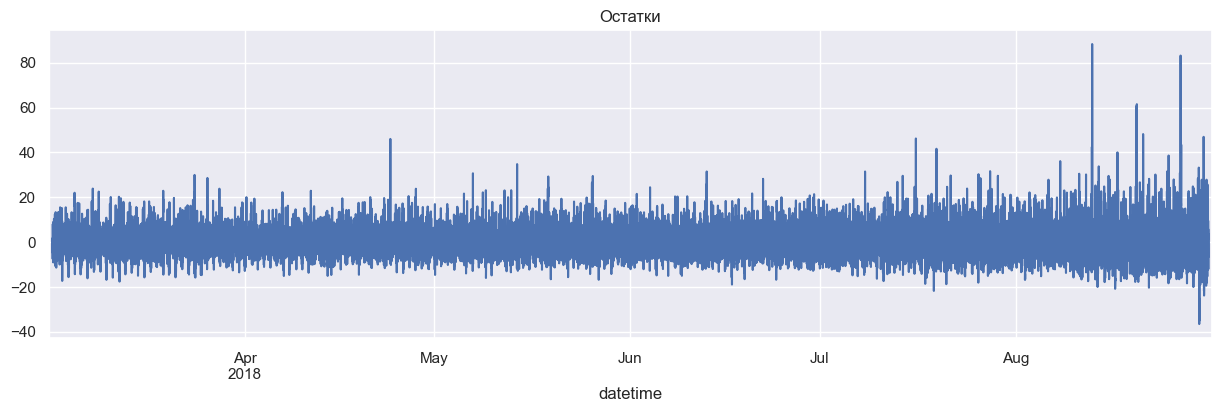

In [20]:
lineplot(decomposed.resid, 'Остатки')

Выводы: 
1. Растущий тренд, связанный, вероятно, с ростом самого сервиса. На увеличение количества заказов также может влиять летний сезон отпусков
2. Дневная сезонность - увеличение количества заказов днем и снижение вечером и ночью
3. Увеличение выбросов в августе

<a id = "isolation-forest"></a>

# Isolation Forest

In [23]:
scaler = StandardScaler()
np_scaled = scaler.fit_transform(df.values.reshape(-1,1))
data = pd.DataFrame(np_scaled)

data.head()

,0
0,-0.002283
1,1.519369
2,0.649854
3,1.954127
4,0.758543


In [24]:
model = IsolationForest(contamination=0.05)
model.fit(data)

IsolationForest(contamination=0.05)

In [25]:
df['anomaly'] = model.predict(data)
df.head()

,data,anomaly
datetime,,
2018-03-01 00:10:00,14.0,1
2018-03-01 00:20:00,28.0,1
2018-03-01 00:30:00,20.0,1
2018-03-01 00:40:00,32.0,1
2018-03-01 00:50:00,21.0,1


                     data
datetime                 
2018-03-03 00:40:00  38.0
2018-03-03 00:50:00  34.0
2018-03-05 01:00:00  42.0
2018-03-07 22:10:00  36.0
2018-03-08 20:50:00  34.0
...                   ...
2018-08-31 22:30:00  41.0
2018-08-31 22:40:00  34.0
2018-08-31 22:50:00  34.0
2018-08-31 23:40:00  39.0
2018-08-31 23:50:00  53.0

[908 rows x 1 columns]


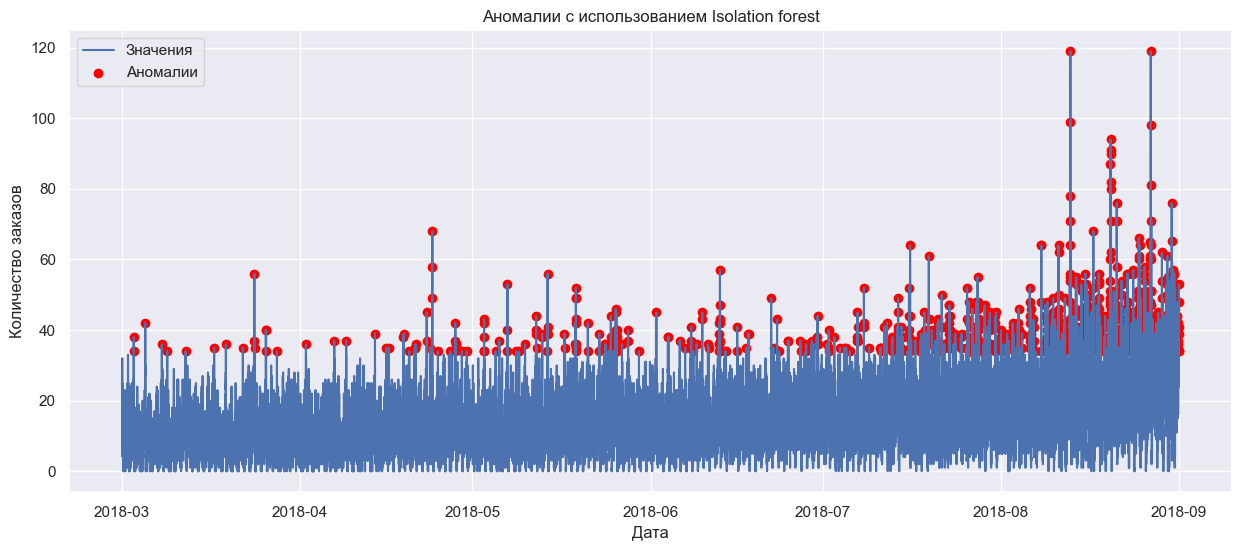

In [26]:
fig, ax = plt.subplots(figsize=(15, 6))
a = df.loc[df.anomaly == -1, ['data']]

print(a)

ax.plot(df.index, df['data'], label='Значения')
ax.scatter(a.index, a['data'], color='red', label='Аномалии', marker='o')
plt.title('Аномалии с использованием Isolation forest')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.legend()
plt.show()

# Z-score

<a id = "z-score"></a>

# С дифференцированием ряда для устранения тренда

Аномальные значения для дифференцированного ряда:
                     data  zscore_diff  anomaly_diff
datetime                                            
2018-03-05 01:00:00  42.0     3.887467          True
2018-03-19 02:00:00  12.0    -3.732417          True
2018-03-23 23:30:00  30.0     3.420944          True
2018-03-23 23:50:00   8.0    -3.110386          True
2018-03-24 00:50:00  56.0     4.198483          True
...                   ...          ...           ...
2018-08-31 01:50:00  32.0     3.265436          True
2018-08-31 04:00:00  50.0     3.109928          True
2018-08-31 05:10:00  13.0    -3.421401          True
2018-08-31 08:10:00  52.0     4.042975          True
2018-08-31 08:30:00  24.0    -3.421401          True

[220 rows x 3 columns]


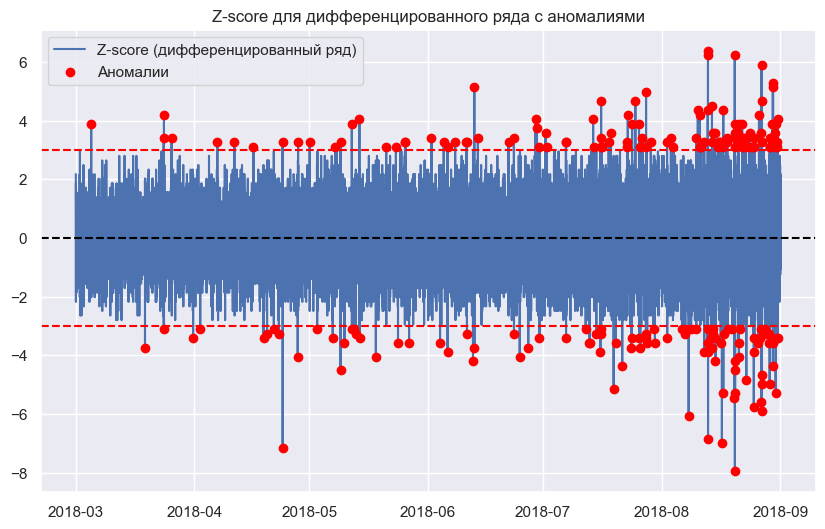

In [56]:
df_diff = df.copy()

df_diff['diff'] = df_diff['data'].diff().dropna()

df_diff['zscore_diff'] = (df_diff['diff'] - df_diff['diff'].mean()) / df_diff['diff'].std()

df_diff['anomaly_diff'] = np.where((df_diff['zscore_diff'] > 3) | (df_diff['zscore_diff'] < -3), True, False)

anomalies_df = df_diff[['data', 'zscore_diff', 'anomaly_diff']].copy()

anomalies_diff = anomalies_df[anomalies_df['anomaly_diff']]
print("Аномальные значения для дифференцированного ряда:")
print(anomalies_diff)

plt.figure(figsize=(10, 6))
plt.plot(df_diff.index, df_diff['zscore_diff'], label='Z-score (дифференцированный ряд)')
plt.scatter(df_diff.index[df_diff['anomaly_diff']], df_diff['zscore_diff'][df_diff['anomaly_diff']], color='red', label='Аномалии', zorder=5)
plt.axhline(3, color='red', linestyle='--')
plt.axhline(-3, color='red', linestyle='--')
plt.axhline(0, color='black', linestyle='--')
plt.title('Z-score для дифференцированного ряда с аномалиями')
plt.legend()
plt.show()

# Z-score с использованием скользящего окна


Аномальные значения для скользящего окна:
                     data  zscore_rolling
datetime                                 
2018-03-01 09:30:00  20.0        3.005830
2018-03-02 08:30:00  12.0        3.369463
2018-03-04 13:50:00  20.0        3.812062
2018-03-05 01:00:00  42.0        3.570652
2018-03-06 09:20:00  15.0        3.163653
...                   ...             ...
2018-08-23 00:50:00  56.0        3.023377
2018-08-26 00:00:00  56.0        3.007095
2018-08-26 23:40:00  65.0        3.150265
2018-08-29 23:20:00  61.0        3.069405
2018-08-31 08:10:00  52.0        3.079102

[94 rows x 2 columns]


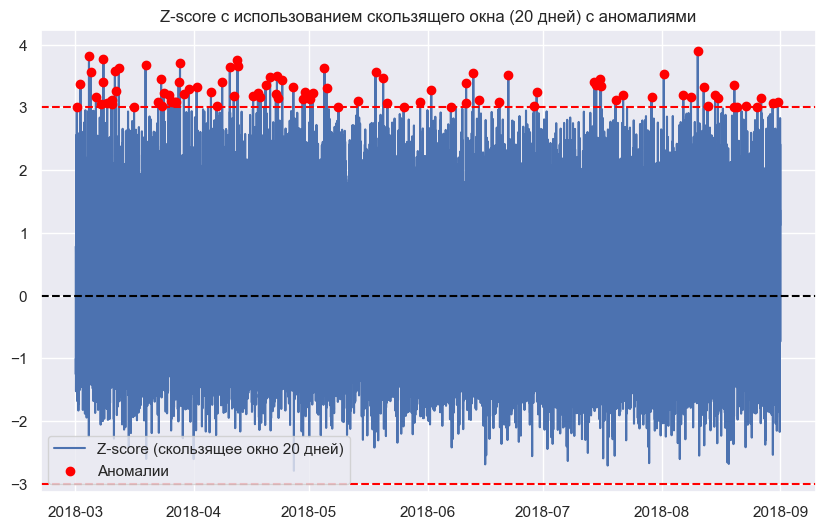

In [30]:
df20 = df.copy()

window = 20  

df20['rolling_mean'] = df20['data'].rolling(window=window).mean()
df20['rolling_std'] = df20['data'].rolling(window=window).std()

df20['zscore_rolling'] = (df20['data'] - df20['rolling_mean']) / df20['rolling_std']

df20['anomaly_rolling'] = np.where((df20['zscore_rolling'] > 3) | (df20['zscore_rolling'] < -3), True, False)

anomalies_rolling = df20[df20['anomaly_rolling']][['data', 'zscore_rolling']]
print("\nАномальные значения для скользящего окна:")
print(anomalies_rolling)

plt.figure(figsize=(10, 6))
plt.plot(df20.index, df20['zscore_rolling'], label=f'Z-score (скользящее окно {window} дней)')
plt.scatter(df20.index[df20['anomaly_rolling']], df20['zscore_rolling'][df20['anomaly_rolling']], color='red', label='Аномалии', zorder=5)
plt.axhline(3, color='red', linestyle='--')
plt.axhline(-3, color='red', linestyle='--')
plt.axhline(0, color='black', linestyle='--')
plt.title(f'Z-score с использованием скользящего окна ({window} дней) с аномалиями')
plt.legend()
plt.show()